In [31]:
import os
import sys
import cv2
import glob
import math
import numpy as np
from PIL import Image
from time import time
from tqdm.notebook import tqdm
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from skimage.io import imread
from skimage.transform import resize
from skimage.util import img_as_float
from scipy import signal
from scipy import interpolate
from scipy.ndimage.filters import gaussian_laplace, gaussian_filter, rank_filter, generic_filter
from pybsds import evaluate_boundaries
from pybsds.bsds_dataset import BSDSDataset

In [11]:
def get_wall_z_image(Z_val, fx, fy, cx, cy, szx, szy):
  Z = Z_val*np.ones((szy, szx), dtype=np.float32)
  return Z

def get_road_z_image(H_val, fx, fy, cx, cy, szx, szy):
  y = np.arange(szy).reshape(-1,1)*1.
  y = np.tile(y, (1, szx))
  Z = np.zeros((szy, szx), dtype=np.float32)
  Z[y > cy] = H_val*fy / (y[y>cy]-cy)
  Z[y <= cy] = np.NaN
  return Z

def plot_optical_flow(ax, Z, u, v, cx, cy, szx, szy, s=16):
  # Here is a function for plotting the optical flow. Feel free to modify this 
  # function to work well with your inputs, for example if your predictions are
  # in a different coordinate frame, etc.
  
  x, y = np.meshgrid(np.arange(szx), np.arange(szy))
  ax.imshow(Z, alpha=0.5, origin='upper')
  q = ax.quiver(x[::s,::s], y[::s,::s], u[::s,::s], -v[::s, ::s])
  # ax.quiverkey(q, X=0.5, Y=0.9, U=20, 
  #              label='Quiver key length = 20', labelpos='N')
  ax.axvline(cx)
  ax.axhline(cy)
  ax.set_xlim([0, szx])
  ax.set_ylim([szy, 0])
  ax.axis('equal')
    
def pixel_velocity(x, y, t, w, Z):
    u = 1 / Z * np.dot([-1, 0, x], t) + np.dot([x * y, -(1 + x ** 2), y], w)
    v = 1 / Z * np.dot([0, -1, y], t) + np.dot([(1 + y ** 2), -x * y, -x], w)
    return u, v

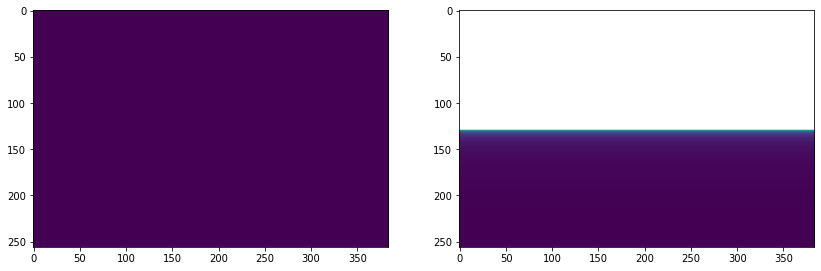

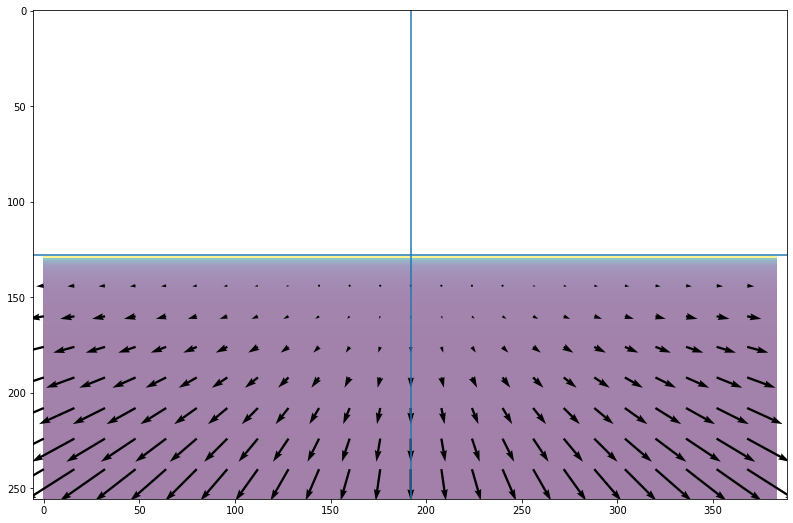

In [78]:
# Focal length along X and Y axis. In class we assumed the smae focal length 
# for X and Y axis. but in general they could be different. We are denoting 
# these by fx and fy.
fx = fy = 128.

# Size of the image
szy = 256
szx = 384

# Center of the image. We are going to assume that the principal point is at 
# the center of the image.
cx = 192
cy = 128

# Gets the image of a wall 2m in front of the camera.
Z1 = get_wall_z_image(2., fx, fy, cx, cy, szx, szy)

# Gets the image of the ground plane that is 3m below the camera.
Z2 = get_road_z_image(3., fx, fy, cx, cy, szx, szy)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,7))
ax1.imshow(Z1)
ax2.imshow(Z2)

# Plotting function.
f = plt.figure(figsize=(13.5,9))
u, v = np.zeros((szy,szx), dtype=np.float32), np.zeros((szy,szx), dtype=np.float32)

idx = 1
Z = Z2
t = np.array([0, 0, 1])
w = np.array([0, 0, 0])
# idx = 2
# Z = Z2
# t = np.array([1, 0, 0])
# w = np.array([0, 0, 0])
# idx = 3
# Z = Z1
# t = np.array([0, 0, 1])
# w = np.array([0, 0, 0])
# idx = 4
# Z = Z1
# t = np.array([50, 50, 1])
# w = np.array([0, 0, 0])
# idx = 5
# Z = Z1
# t = np.array([0, 0, 1])
# w = np.array([0, -1, 0])

for y in range(szy):
    for x in range(szx):
        u[y,x], v[y,x] = pixel_velocity(x-cx, y-cy, t, w, Z[y,x])

plot_optical_flow(f.gca(), Z, u, v, cx, cy, szx, szy, s=16)
f.savefig('optical-flow-output/optical_flow_output%d.png' % idx, bbox_inches='tight')

## Part 2

In [17]:
def get_imlist(name):
    imlist = np.loadtxt('contour-data/{}.imlist'.format(name))
    return imlist.astype(np.int)

def edge_nonmax_suppression(img, angle, threshold = 0):
    h, w = img.shape
    
    for i in range(1, h-1):
        for j in range(1, w-1):
            if img[i,j] < threshold:
                continue
                
            p, q = 1, 1
            if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                p = img[i, j+1]
                q = img[i, j-1]
            elif (22.5 <= angle[i,j] < 67.5):
                p = img[i+1, j-1]
                q = img[i-1, j+1]
            elif (67.5 <= angle[i,j] < 112.5):
                p = img[i+1, j]
                q = img[i-1, j]
            elif (112.5 <= angle[i,j] < 157.5):
                p = img[i-1, j-1]
                q = img[i+1, j+1]
            
            if (img[i,j] < p) or (img[i,j] < q):
                img[i,j] = 0
            
    return img

def hysteresis(img, low_thres=10.0, high_thres=220.0):
    h, w = img.shape
    high_thres = high_thres / 255
    low_thres = low_thres / 255
    
    y, x = np.where(img >= high_thres)
    img[y,x] = 1.
    y, x = np.where((img <= high_thres) & (img >= low_thres))
    img[y,x] = 0.1
    y, x = np.where(img < low_thres)
    img[y,x] = 0.
    
    for i in range(1, h-1):
        for j in range(1, w-1):
            if img[i,j] == 0. or img[i,j] == 1.:
                continue
            
            if img[i+1, j-1] or img[i+1, j] or img[i+1, j+1] or img[i, j-1] or img[i, j+1] or img[i-1, j-1] or img[i-1, j] or img[i-1, j+1]:
                img[i, j] = 1.
            else:
                img[i, j] = 0
    
    return img

def compute_edges_dxdy0(I):
    """Returns the norm of dx and dy as the edge response function."""
    I = I.astype(np.float32)/255.
    dx = signal.convolve2d(I, np.array([[-1, 0, 1]]), mode='same')
    dy = signal.convolve2d(I, np.array([[-1, 0, 1]]).T, mode='same')
    mag = np.sqrt(dx**2 + dy**2)
    mag = mag / np.max(mag)
    mag = mag * 255.
    mag = np.clip(mag, 0, 255)
    mag = mag.astype(np.uint8)
    return mag

def compute_edges_dxdy(I):
    """Returns the norm of dx and dy as the edge response function."""
    I = I.astype(np.float32)/255.
    dx = signal.convolve2d(I, np.array([[-1, 0, 1]]), boundary='symm', mode='same')
    dy = signal.convolve2d(I, np.array([[-1, 0, 1]]).T, boundary='symm', mode='same')
    mag = np.sqrt(dx**2 + dy**2)
    mag = mag / np.max(mag)
    mag = mag * 255.
    mag = np.clip(mag, 0, 255)
    mag = mag.astype(np.uint8)
    return mag

def compute_edges_gaussian(I):
    I = I.astype(np.float32)/255.
    dx = gaussian_filter(I, sigma=1, order=(0,1))
    dy = gaussian_filter(I, sigma=1, order=(1,0))
    mag = np.sqrt(dx**2 + dy**2)
    mag = mag / np.max(mag)
    mag = mag * 255.
    mag = np.clip(mag, 0, 255.0)
    mag = mag.astype(np.uint8)
    return mag

def compute_edges_nms(I):
    """Returns the norm of dx and dy as the edge response function."""
    I = I.astype(np.float32)/255.
    dx = gaussian_filter(I, sigma=1, order=(0,1))
    dy = gaussian_filter(I, sigma=1, order=(1,0))
    mag = np.sqrt(dx**2 + dy**2)
    mag = mag / np.max(mag)
    
    # nonmax suppression
    theta = np.arctan2(-dy, dx)
    angle = theta * 180. / np.pi
    angle[angle < 0] += 180
    mag = edge_nonmax_suppression(mag, angle)
    
    mag = mag * 255.
    mag = np.clip(mag, 0, 255.0)
    mag = mag.astype(np.uint8)
    return mag

def compute_edges_canny(I):
    """Returns the norm of dx and dy as the edge response function."""
    I = I.astype(np.float32)/255.
    dx = gaussian_filter(I, sigma=2, order=(0,1))
    dy = gaussian_filter(I, sigma=2, order=(1,0))
    mag = np.sqrt(dx**2 + dy**2)
    mag = mag / np.max(mag)
    
    # nonmax suppression
    theta = np.arctan2(-dy, dx)
    angle = theta * 180. / np.pi
    angle[angle < 0] += 180
    mag = edge_nonmax_suppression(mag, angle)
    
    # hysteresis
    mag = hysteresis(mag, low_thres=35, high_thres=50)
    
    mag = mag * 255.
    mag = np.clip(mag, 0, 255.0)
    mag = mag.astype(np.uint8)
    return mag

def detect_edges(imlist, fn, out_dir):
    for imname in tqdm(imlist):
        I = cv2.imread(os.path.join(IMAGE_DIR, str(imname)+'.jpg'))
        gray = cv2.cvtColor(I, cv2.COLOR_BGR2GRAY)
        mag = fn(gray)
        out_file_name = os.path.join(out_dir, str(imname)+'.png')
        cv2.imwrite(out_file_name, mag)     

def load_gt_boundaries(imname):
    gt_path = os.path.join(GT_DIR, '{}.mat'.format(imname))
    return BSDSDataset.load_boundaries(gt_path)

def load_pred(output_dir, imname):
    pred_path = os.path.join(output_dir, '{}.png'.format(imname))
    return img_as_float(imread(pred_path))

def display_results(ax, f, im_results, threshold_results, overall_result):
    out_keys = ['threshold', 'f1', 'best_f1', 'area_pr']
    out_name = ['threshold', 'overall max F1 score', 'average max F1 score',
              'area_pr']
    for k, n in zip(out_keys, out_name):
        print('{:>20s}: {:<10.6f}'.format(n, getattr(overall_result, k)))
        f.write('{:>20s}: {:<10.6f}\n'.format(n, getattr(overall_result, k)))
    res = np.array(threshold_results)
    recall = res[:,1]
    precision = res[recall>0.01,2]
    recall = recall[recall>0.01]
    label_str = '{:0.2f}, {:0.2f}, {:0.2f}'.format(
    overall_result.f1, overall_result.best_f1, overall_result.area_pr)
    # Sometimes the PR plot may look funny, such as the plot curving back, i.e,
    # getting a lower recall value as you lower the threshold. This is because of
    # the lack on non-maximum suppression. The benchmarking code does some
    # contour thinning by itself. Unfortunately this contour thinning is not very
    # good. Without having done non-maximum suppression, as you lower the
    # threshold, the contours become thicker and thicker and we lose the
    # information about the precise location of the contour. Thus, a thined
    # contour that corresponded to a ground truth boundary at a higher threshold
    # can end up far away from the ground truth boundary at a lower threshold.
    # This leads to a drop in recall as we decrease the threshold.
    ax.plot(recall, precision, 'r', lw=2, label=label_str)
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])
    ax.grid(True)
    ax.legend()
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')

Running detector:



Evaluating:



           threshold: 0.010000  
overall max F1 score: 0.620529  
average max F1 score: 0.620529  
             area_pr: 0.000000  


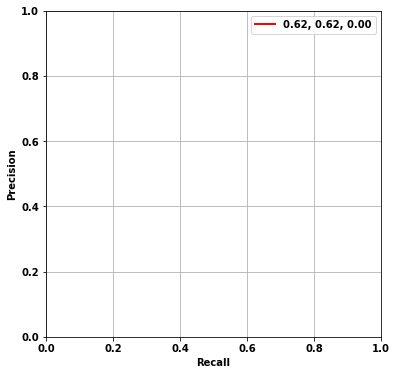

In [18]:
sys.path.insert(0, 'pybsds')

GT_DIR = os.path.join('contour-data', 'groundTruth')
IMAGE_DIR = os.path.join('contour-data', 'images')
N_THRESHOLDS = 99

imset = 'val'
imlist = get_imlist(imset)
output_dir = 'contour-output/demo'; fn = compute_edges_canny;
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print('Running detector:')
detect_edges(imlist, fn, output_dir)
  
_load_pred = lambda x: load_pred(output_dir, x)
print('Evaluating:')
sample_results, threshold_results, overall_result = \
evaluate_boundaries.pr_evaluation(N_THRESHOLDS, imlist, load_gt_boundaries, _load_pred, fast=True, progress=tqdm)
fig = plt.figure(figsize=(6,6))
ax = fig.gca()
file_name = os.path.join(output_dir + '_out.txt')
with open(file_name, 'wt') as f:
    display_results(ax, f, sample_results, threshold_results, overall_result)
fig.savefig(os.path.join(output_dir + '_pr.pdf'), bbox_inches='tight')
plt.show()

## Part 3

In [33]:
def gray_scale(path):
    return np.array(Image.open(path).convert('L')) / 255
    
def laplacian_scale(img, sigma, k, level):
    h, w = img.shape
    output = np.empty((h, w, level))
    
    for i in range(level):
        output[:,:,i] = np.square(sigma**2 * gaussian_laplace(img, sigma=sigma))
        sigma *= k
    return output

def laplacian_downsample(img, sigma, k, level):
    h, w = img.shape
    output = np.empty((h, w, level))
    scale = 1

    for i in range(level):
        down = resize(img, (math.ceil(h/scale), math.ceil(w/scale)))
        output[:, :, i] = resize(np.square(gaussian_laplace(down, sigma=sigma)), (h, w))
        scale *= k
    return output

def nonmax_suppression(space, size):
    h, w, level = space.shape
    output = np.zeros_like(space)
    tmp = np.copy(space)
    
    
    for i in range(level):
        tmp[:,:,i] = rank_filter(tmp[:,:,i], -1, size=size)
    value = np.amax(rank_filter(tmp, -1, size=size), axis=2)
    
    for i in range(level):
        output[:,:,i] = (space[:,:,i] == value) * space[:,:,i]
        
    return output

def calculate_circles(centers, sigma, k, threshold = 0.001):
    h, w, level = centers.shape
    cx, cy, rad = [], [], []
    
    for i in range(level):
        idx = np.where(centers[:,:,i] > threshold)
        cy += idx[0].tolist()
        cx += idx[1].tolist()
        rad += np.repeat(math.sqrt(2)*sigma, len(idx[0])).tolist()
        sigma *= k
    
    return cx, cy, rad

def show_all_circles(image, cx, cy, rad, color='r'):
    """
    image: numpy array, representing the grayscsale image
    cx, cy: numpy arrays or lists, centers of the detected blobs
    rad: numpy array or list, radius of the detected blobs
    """
    
    fig, ax = plt.subplots()
    ax.set_aspect('equal')
    ax.imshow(image, cmap='gray')
    for x, y, r in zip(cx, cy, rad):
        circ = Circle((x, y), r, color=color, fill=False)
        ax.add_patch(circ)

    plt.title('%i circles' % len(cx))
    plt.show()
    fig.savefig('%i circles' % len(cx))

def blob_detection(path, sigma = 2,  k = 2, level = 10, size = 5):
    img = gray_scale(path)
    scale_space = laplacian_downsample(img, sigma, k, level)
    centers = nonmax_suppression(scale_space, size)
    cx, cy, rad = calculate_circles(centers, sigma, k)
    show_all_circles(img, cx, cy, rad)

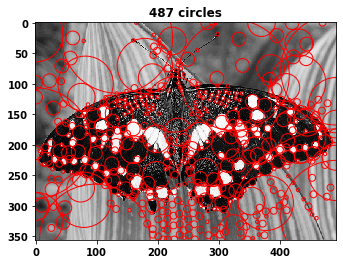

In [23]:
# parameters
sigma = 2
k = 2
level = 10
size = 5

img = gray_scale('blobs-data/butterfly.jpg')
scale_space = laplacian_scale(img, sigma, k, level)
centers = nonmax_suppression(scale_space, size)
cx, cy, rad = calculate_circles(centers, sigma, k)
show_all_circles(img, cx, cy, rad)

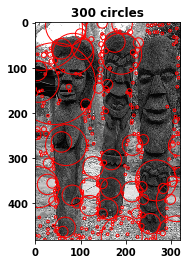

1.45615816116333


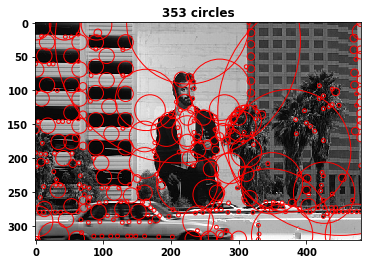

1.5950801372528076


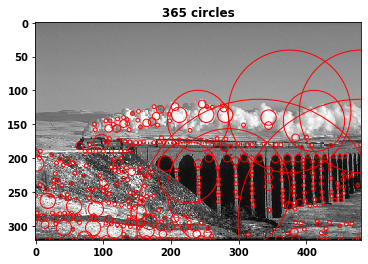

1.5421102046966553


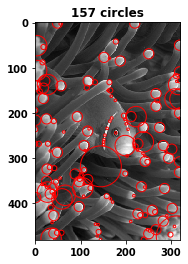

1.1913127899169922


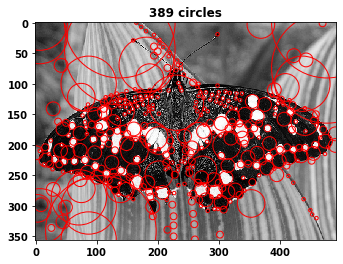

1.7569870948791504


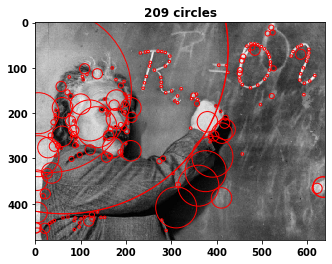

2.285682201385498


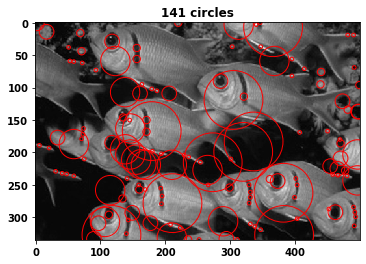

1.3522202968597412


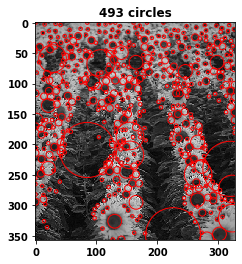

1.4481751918792725


In [34]:
paths = glob.glob("blobs-data/" + "*.jpg")
for p in paths:
    start_time = time()
    blob_detection(p, sigma = 2,  k = 2, level = 10, size = 5)
    print(time() - start_time)